In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers


class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=16, kernel_size=(3,3), 
            padding='same', activation=tf.nn.relu)
        self.maxpool1 = tf.keras.layers.MaxPool2D(
            pool_size=(2,2), strides=(2,2), 
            padding='same')
        self.conv2 = tf.keras.layers.Conv2D(
            filters=8, kernel_size=(3,3), 
            padding='same', activation=tf.nn.relu)
        self.maxpool2 = tf.keras.layers.MaxPool2D(
            pool_size=(2,2), strides=(2,2),
            padding='same')
        self.conv3 = tf.keras.layers.Conv2D(
            filters=8, kernel_size=(3,3), 
            padding='same', activation=tf.nn.relu)
        self.encoded = tf.keras.layers.MaxPool2D(
            pool_size=(2,2), strides=(2,2), 
            padding='same')
            
    @tf.function
    def call(self, input_features):
        latent1 = self.conv1(input_features)
        latent2 = self.maxpool1(latent1)
        latent3 = self.conv2(latent2)
        latent4 = self.maxpool2(latent3)
        latent5 = self.conv3(latent4)
        return self.encoded(latent5) 
  

class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=8, kernel_size=(3,3), 
            padding='same', activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=8, kernel_size=(3,3), 
            padding='same', activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(
            filters=16, kernel_size=(3,3), 
            padding='same', activation=tf.nn.relu)
        self.conv4 = tf.keras.layers.Conv2D(
            filters=1, kernel_size=(3,3), 
            padding='same', activation=None)
            
    @tf.function
    def call(self, code):
        latent6 = tf.image.resize(code, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        latent7 =  self.conv1(latent6) 
        latent8 = tf.image.resize(latent7, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        latent9 = self.conv2(latent8)
        latent10 = tf.image.resize(latent9, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        latent11 = self.conv3(latent10)
        logits = self.conv4(latent11)
        return logits

class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @tf.function
    def call(self, input_features):
        code = self.encoder(input_features)
        logits = self.decoder(code)
        return logits
    
    def reconstruct(self, input_features):
        code = self.encoder(input_features)
        logits = self.decoder(code)
        return tf.nn.sigmoid(logits)

def reconstruction_loss(y_actual, y_predicted):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_actual, logits=y_predicted)
    
    
cae = Autoencoder()
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
cae.compile(optimizer, loss=reconstruction_loss)

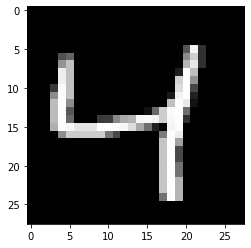

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
x_train = mnist.data.reshape(mnist.data.shape[0], 28, 28, 1).astype('float32')
x_train /= 255.
img = x_train[2]
plt.imshow(img.reshape((28,28)), cmap='Greys_r')

In [3]:
cae.fit(x_train, x_train, epochs=20, batch_size=200, shuffle=True)

Train on 70000 samples
Epoch 1/20
70000/70000 [==============================] - 82s 1ms/sample - loss: 0.2231
Epoch 2/20
70000/70000 [==============================] - 82s 1ms/sample - loss: 0.1369
Epoch 3/20
70000/70000 [==============================] - 81s 1ms/sample - loss: 0.1230
Epoch 4/20
70000/70000 [==============================] - 81s 1ms/sample - loss: 0.1160
Epoch 5/20
70000/70000 [==============================] - 80s 1ms/sample - loss: 0.1119
Epoch 6/20
70000/70000 [==============================] - 77s 1ms/sample - loss: 0.1091
Epoch 7/20
70000/70000 [==============================] - 77s 1ms/sample - loss: 0.1069
Epoch 8/20
70000/70000 [==============================] - 78s 1ms/sample - loss: 0.1052
Epoch 9/20
70000/70000 [==============================] - 77s 1ms/sample - loss: 0.1038
Epoch 10/20
70000/70000 [==============================] - 78s 1ms/sample - loss: 0.1025
Epoch 11/20
70000/70000 [==============================] - 78s 1ms/sample - loss: 0.1015
Epoch 1

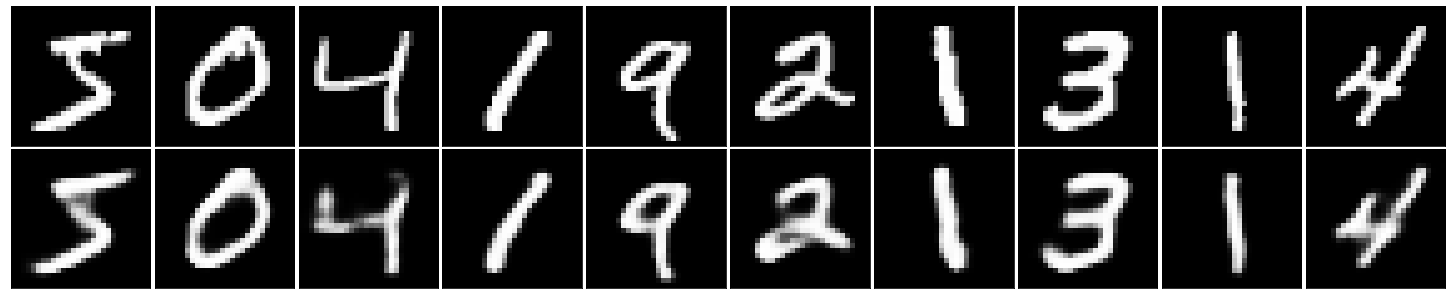

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_train[:10]
reconstructed = cae.reconstruct(in_imgs)

for images, row in zip([in_imgs, reconstructed.numpy()], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [12]:
from data_gen import *

emb = cae.encoder(x_train)
emb = tf.reshape(emb, [emb.shape[0],-1])
Datasets.save_obj(emb.numpy(), 'MNIST_CAE')